In [63]:
## Dependencies 
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [2]:
## Import the embeddings
path = 'data/embeddings/embeddings.npy'
emb = np.load(path)
print("Embeddings are of the shape {}".format(emb.shape))
print("Column {} is the labels corresponding to each embedding".format(emb.shape[1]))

Embeddings are of the shape (70000, 197)
Column 197 is the labels corresponding to each embedding


In [3]:
## splitting into test and train embeddings
idx = np.random.permutation(70000)
emb_train = emb[idx[:60000]]
emb_test = emb[idx[60000:]]

In [28]:
"""
- Decide on k values
- Calculate distance of each test instance with database and append to list
- Sort in descending order
- Pick the first 'k' values and assign test emb to majority clas
- Calculate the error

"""
emb_train = emb[idx[:60000]]
emb_test = emb[idx[60000:]]


k_test = 100
predictions = dict()

for k in range(1,k_test+1) : predictions[k] = list()

for test_inst in tqdm(emb_test):

    ## Calculate the distance of each test instance from train instances 
    test_inst = test_inst[:-1]
    test_inst = test_inst.reshape(1,-1)
    test_inst = test_inst.repeat(60000, axis=0)
    temp_dist = np.linalg.norm((test_inst - emb_train[:,:-1]), axis=1)

    ## Store distance and respective labels in tuples in a list
    temp_dist_idx = [(temp_dist[i],emb_train[:,-1][i]) for i in range(len(emb_train))]
    temp_dist_idx.sort()

    for k in range(1,k_test+1):
    
        ## Choose first k elements from sorted list 'temp_dist_idx'
        temp_first_k = temp_dist_idx[:k]
        temp_labels = [digit[1] for digit in temp_first_k]

        ## Pick label that has majority count and append to prediction list
        temp_list = [temp_digits.count(i) for i in temp_labels]
        predictions[k].append(temp_labels[temp_list.index(max(temp_list))])
        
    ## Similarity and accuracy calculation 
    sim_pred = sum(predictions[k] == emb_test[:,-1])
    accuracy.append((sim_pred/len(emb_test),k))

name = "predictions_knn"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)




  0%|          | 0/10000 [00:00<?, ?it/s]

hey





  0%|          | 1/10000 [00:00<40:31,  4.11it/s]

[1]





  0%|          | 2/10000 [00:00<38:24,  4.34it/s]

[1]





  0%|          | 3/10000 [00:00<38:10,  4.37it/s]

[1]





  0%|          | 4/10000 [00:01<42:21,  3.93it/s]

[1]





  0%|          | 5/10000 [00:01<40:56,  4.07it/s]

[1]





  0%|          | 6/10000 [00:01<41:50,  3.98it/s]

[1]





  0%|          | 7/10000 [00:01<41:55,  3.97it/s]


  0%|          | 8/10000 [00:01<40:45,  4.09it/s]

[1]
[1]





  0%|          | 9/10000 [00:02<42:03,  3.96it/s]

[1]





  0%|          | 10/10000 [00:02<45:24,  3.67it/s]

[1]





  0%|          | 11/10000 [00:02<45:19,  3.67it/s]

[1]





  0%|          | 12/10000 [00:03<46:52,  3.55it/s]

[1]





  0%|          | 13/10000 [00:03<46:11,  3.60it/s]

[1]





  0%|          | 14/10000 [00:03<47:14,  3.52it/s]

[1]





  0%|          | 15/10000 [00:04<47:53,  3.47it/s]

[1]





  0%|          | 16/10000 [00:04<48:28,  3.43it/s]

[1]





  0%|          | 17/10000 [00:05<49:11,  3.38it/s]

[1]


/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



  0%|          | 18/10000 [00:05<49:14,  3.38it/s]

[1]





  0%|          | 19/10000 [00:05<49:04,  3.39it/s]

[1]





  0%|          | 20/10000 [00:05<49:22,  3.37it/s]

[1]





  0%|          | 21/10000 [00:06<49:10,  3.38it/s]

[1]





  0%|          | 22/10000 [00:06<48:47,  3.41it/s]

[1]





  0%|          | 23/10000 [00:06<48:49,  3.41it/s]

[1]





  0%|          | 24/10000 [00:06<48:27,  3.43it/s]

[1]





  0%|          | 25/10000 [00:07<48:13,  3.45it/s]

[1]





  0%|          | 26/10000 [00:07<48:17,  3.44it/s]

[1]





  0%|          | 27/10000 [00:07<47:59,  3.46it/s]

[1]





  0%|          | 28/10000 [00:08<47:42,  3.48it/s]

[1]





  0%|          | 29/10000 [00:08<47:31,  3.50it/s]

[1]





  0%|          | 30/10000 [00:08<47:57,  3.46it/s]

[1]





  0%|          | 31/10000 [00:08<47:42,  3.48it/s]

[1]
[1]




  0%|          | 32/10000 [00:09<47:14,  3.52it/s]


  0%|          | 33/10000 [00:09<46:59,  3.54it/s]


[1]





  0%|          | 34/10000 [00:09<46:51,  3.54it/s]

[1]





  0%|          | 35/10000 [00:09<47:18,  3.51it/s]

[1]





  0%|          | 36/10000 [00:10<47:44,  3.48it/s]

[1]





  0%|          | 37/10000 [00:10<47:46,  3.48it/s]

[1]





  0%|          | 38/10000 [00:10<47:25,  3.50it/s]

[1]





  0%|          | 39/10000 [00:11<47:43,  3.48it/s]

[1]





  0%|          | 40/10000 [00:11<47:48,  3.47it/s]

[1]





  0%|          | 41/10000 [00:11<47:46,  3.47it/s]

[1]





  0%|          | 42/10000 [00:12<47:44,  3.48it/s]

[1]





  0%|          | 43/10000 [00:12<47:41,  3.48it/s]

[1]





  0%|          | 44/10000 [00:12<48:00,  3.46it/s]

[1]





  0%|          | 45/10000 [00:13<48:13,  3.44it/s]

[1]





  0%|          | 46/10000 [00:13<48:16,  3.44it/s]

[1]





  0%|          | 47/10000 [00:13<47:58,  3.46it/s]

[1]





  0%|          | 48/10000 [00:13<47:57,  3.46it/s]

[1]





  0%|          | 49/10000 [00:14<48:05,  3.45it/s]

[1]





  0%|          | 50/10000 [00:14<48:31,  3.42it/s]

[1]





  1%|          | 51/10000 [00:15<48:57,  3.39it/s]

[1]





  1%|          | 52/10000 [00:15<48:59,  3.38it/s]

[1]





  1%|          | 53/10000 [00:15<48:54,  3.39it/s]

[1]





  1%|          | 54/10000 [00:15<48:49,  3.39it/s]

[1]





  1%|          | 55/10000 [00:16<48:47,  3.40it/s]

[1]





  1%|          | 56/10000 [00:16<48:36,  3.41it/s]

[1]





  1%|          | 57/10000 [00:16<48:27,  3.42it/s]

[1]





  1%|          | 58/10000 [00:16<48:19,  3.43it/s]

[1]





  1%|          | 59/10000 [00:17<48:07,  3.44it/s]

[1]





  1%|          | 60/10000 [00:17<48:11,  3.44it/s]

[1]





  1%|          | 61/10000 [00:17<48:25,  3.42it/s]

[1]





  1%|          | 62/10000 [00:18<48:15,  3.43it/s]

[1]





  1%|          | 63/10000 [00:18<48:02,  3.45it/s]

[1]





  1%|          | 64/10000 [00:18<47:54,  3.46it/s]

[1]





  1%|          | 65/10000 [00:18<48:06,  3.44it/s]

[1]





  1%|          | 66/10000 [00:19<48:03,  3.45it/s]

[1]





  1%|          | 67/10000 [00:19<47:53,  3.46it/s]

[1]





  1%|          | 68/10000 [00:19<47:54,  3.46it/s]

[1]





  1%|          | 69/10000 [00:19<47:54,  3.46it/s]

[1]





  1%|          | 70/10000 [00:20<47:55,  3.45it/s]

[1]





  1%|          | 71/10000 [00:20<47:57,  3.45it/s]

[1]





  1%|          | 72/10000 [00:20<47:55,  3.45it/s]

[1]





  1%|          | 73/10000 [00:21<47:49,  3.46it/s]

[1]





  1%|          | 74/10000 [00:21<47:41,  3.47it/s]

[1]





  1%|          | 75/10000 [00:21<47:35,  3.48it/s]

[1]





  1%|          | 76/10000 [00:21<47:41,  3.47it/s]

[1]





  1%|          | 77/10000 [00:22<47:40,  3.47it/s]

[1]





  1%|          | 78/10000 [00:22<47:35,  3.47it/s]

[1]





  1%|          | 79/10000 [00:22<47:27,  3.48it/s]

[1]





  1%|          | 80/10000 [00:22<47:25,  3.49it/s]

[1]





  1%|          | 81/10000 [00:23<47:18,  3.49it/s]

[1]





  1%|          | 82/10000 [00:23<47:09,  3.51it/s]

[1]





  1%|          | 83/10000 [00:23<47:01,  3.51it/s]

[1]





  1%|          | 84/10000 [00:23<46:52,  3.53it/s]

[1]





  1%|          | 85/10000 [00:24<46:44,  3.54it/s]

[1]





  1%|          | 86/10000 [00:24<46:36,  3.55it/s]

[1]





  1%|          | 87/10000 [00:24<46:42,  3.54it/s]


  1%|          | 88/10000 [00:24<46:32,  3.55it/s]

[1]
[1]





  1%|          | 89/10000 [00:25<46:28,  3.55it/s]

[1]





  1%|          | 90/10000 [00:25<46:32,  3.55it/s]

[1]





  1%|          | 91/10000 [00:25<46:26,  3.56it/s]

[1]





  1%|          | 92/10000 [00:25<46:38,  3.54it/s]

[1]





  1%|          | 93/10000 [00:26<46:50,  3.52it/s]

[1]





  1%|          | 94/10000 [00:26<46:46,  3.53it/s]

[1]





  1%|          | 95/10000 [00:26<46:50,  3.52it/s]

[1]





  1%|          | 96/10000 [00:27<46:49,  3.52it/s]

[1]





  1%|          | 97/10000 [00:27<46:53,  3.52it/s]

[1]





  1%|          | 98/10000 [00:27<47:04,  3.51it/s]

[1]





  1%|          | 99/10000 [00:28<47:14,  3.49it/s]

[1]





  1%|          | 100/10000 [00:28<47:25,  3.48it/s]

[1]





  1%|          | 101/10000 [00:29<47:29,  3.47it/s]

[1]





  1%|          | 102/10000 [00:29<47:23,  3.48it/s]

[1]





  1%|          | 103/10000 [00:29<47:22,  3.48it/s]

[1]





  1%|          | 104/10000 [00:29<47:15,  3.49it/s]

[1]





  1%|          | 105/10000 [00:30<47:24,  3.48it/s]

[1]





  1%|          | 106/10000 [00:30<47:17,  3.49it/s]




[1]
[1]


  1%|          | 107/10000 [00:30<47:09,  3.50it/s]


  1%|          | 108/10000 [00:30<47:02,  3.51it/s]

[1]





  1%|          | 109/10000 [00:31<46:54,  3.51it/s]

[1]





  1%|          | 110/10000 [00:31<46:51,  3.52it/s]

[1]





  1%|          | 111/10000 [00:31<46:44,  3.53it/s]

[1]





  1%|          | 112/10000 [00:31<46:38,  3.53it/s]

[1]





  1%|          | 113/10000 [00:31<46:33,  3.54it/s]

[1]





  1%|          | 114/10000 [00:32<46:26,  3.55it/s]

[1]





  1%|          | 115/10000 [00:32<46:20,  3.56it/s]

[1]


KeyboardInterrupt: 

In [46]:
name = "predictions_knn"
with open(name + '.pkl', 'wb') as f:
    pickle.dump(predictions, f, pickle.HIGHEST_PROTOCOL)
    
"""
with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f) """

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


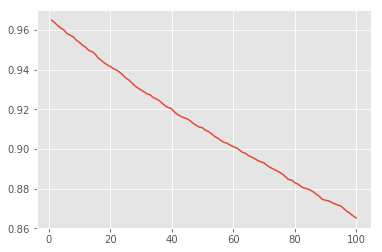

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [64]:
## Plotting accuracy vs K value curve
acc_k = [val[1] for val in accuracy]
acc_val = [val[0] for val in accuracy]

plt.plot(acc_k, acc_val)
plt.show()

In [65]:
accuracy

[(0.9649, 1),
 (0.9636, 2),
 (0.9621, 3),
 (0.9609, 4),
 (0.9599, 5),
 (0.9581, 6),
 (0.9574, 7),
 (0.9565, 8),
 (0.9548, 9),
 (0.9537, 10),
 (0.9523, 11),
 (0.9513, 12),
 (0.9497, 13),
 (0.9492, 14),
 (0.948, 15),
 (0.946, 16),
 (0.9448, 17),
 (0.9435, 18),
 (0.9424, 19),
 (0.9416, 20),
 (0.9405, 21),
 (0.9398, 22),
 (0.9388, 23),
 (0.9375, 24),
 (0.9358, 25),
 (0.9348, 26),
 (0.9334, 27),
 (0.9318, 28),
 (0.9307, 29),
 (0.9298, 30),
 (0.9288, 31),
 (0.9277, 32),
 (0.9273, 33),
 (0.9259, 34),
 (0.9252, 35),
 (0.9243, 36),
 (0.9229, 37),
 (0.9216, 38),
 (0.9208, 39),
 (0.9202, 40),
 (0.9185, 41),
 (0.9173, 42),
 (0.9164, 43),
 (0.9157, 44),
 (0.9152, 45),
 (0.9142, 46),
 (0.9129, 47),
 (0.9119, 48),
 (0.911, 49),
 (0.9107, 50),
 (0.9094, 51),
 (0.9087, 52),
 (0.9076, 53),
 (0.9063, 54),
 (0.9054, 55),
 (0.9043, 56),
 (0.9033, 57),
 (0.9029, 58),
 (0.9019, 59),
 (0.9012, 60),
 (0.9006, 61),
 (0.8995, 62),
 (0.8983, 63),
 (0.8978, 64),
 (0.8966, 65),
 (0.8959, 66),
 (0.8951, 67),
 (0.894

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
